# Clasificación de secuencias genómicas

## Temas:
1. Introducción
  - Objetivos
  - Antecedentes y usos
  - Datos genómicos

2. Preprocesamiento básico de secuencias genómicas
  - Resumen de secuencias genómicas y su representación
  - Transformación y extracción de características (tokenización)
  - Actividad: Preparación de un conjunto de datos

3. Modelos de aprendizaje automático para clasificación de secuencias
  - Métodos clásicos de aprendizaje automático (machine learning)
  - Aprendizaje profundo (deep learning)
  - Actividad: Construcción y entrenamiento de modelos

4. Técnicas avanzadas para la clasificación de secuencias
  - Introducción a modelos de aprendizaje profundo con PyTorch
  - *Transfer learning* con HuggingFace
  ---

# Introducción

## Objetivos:
1. Entender la importancia del proceso de clasificación de secuencias
2. Entender el proceso de preparación de conjuntos de datos para la clasificación de secuencias genómicas
3. Comprender las distintas estrategias disponibles para la clasificación de secuencias
4. Implementar un algoritmo de clasificación de secuencias codificantes vs. no codificantes exitosamente

## Antecedentes
El término **genoma** se refiere a todo el material genético heredable de un ser vivo. La principal diferencia entre la genética y la genómica es el objetivo de estudio. El primero estudia **genes** individuales, así como sus productos y consecuencias de su variación. Mientras que la genómica se centra en todos los elementos que se encuentran en el genóma y cómo estos interaccionan [1]. La rama de la **genómica funcional** estudia cómo los genes y las regiones intergénicas, afectados por el ambiente resultan en fenotipos específicos, es decir, las características visibles de un organismo (color de piel, de ojos, enfermedades manifestadas, etc.) [2].

<figure>
<img    src="images/dna_double_helix.jpg"
        width=500
        height=500>
<figcaption>Fig. 1: Imagen generada de la doble hélice de la estructura del ADN.
</figure>

Tradicionalmente la clasificación de secuencias era un proceso predominantemente estadístico, sin embargo, en los últimos años el uso de herramientas de aprendizaje automático, específicamente de aprendizaje profundo, han servido para identificar y clasificar numerosos elementos genómicos. Por ejemplo, elementos como promotores, potenciadores, factores de transcripción, entre otros, han sido de mucha utilidad para comprobar la efectividad de estas novedosas estrategias [3].

<figure>
<img    src="images/IA_ML_DL.png"
        width=500
        height=500>
<figcaption>Fig. 2: Diagrama de Venn del paradigma de inteligencia artificial.
</figure>

En este taller veremos cuál es el proceso para la clasificación de secuencias genómicas desde el minado y preporcesamiento de los datos, hasta el uso de herramientas más avanzadas. De manera general, este procedimiento se resume en los siguientes pasos:

1. Entender el problema
2. Adquisición y/o búsqueda de datos
3. Pre-procesamiento de datos
4. Extracción de características
5. Elección de modelo o arquitectura
6. Entrenamiento del modelo
7. Evaluación del modelo
8. Despliegue del modelo (en aplicaciones prácticas e industriales)

<figure>
<img    src="images/ml_workflow.png"
        width=1200
        height=200>
<figcaption>Fig. 3: Flujo de trabajo convencional en el uso de herramientas de ML en aplicaciones biomédicas [4].
</figure>

---

# Preprocesamiento básico de secuencias genómicas

In [24]:
# Importaremos algunas librerías que nos serán de mucha utilidad
import torch
import torch.nn as nn
import numpy as np
from Bio import SeqIO
import pandas as pd
import gzip
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn import datasets, decomposition
import matplotlib.pyplot as plt
import seaborn as sns

## Secuencias codificantes vs. no codificantes
El conjunto de datos con el que trabajaremos está disponible en la base de datos pública de Ensembl, disponible [aquí](https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/) en su formato crudo.

El que utilizaremos para este taller está disponible en [esta](https://drive.google.com/drive/folders/1hYwhOeg5xHI7nBzQHFWOGZyXCMbC3Mib?usp=sharing) carpeta de drive. El procedimiento de cómo acceder al conjunto de datos se muestra a continuación.

Al hacer click en el enlace, se abrirá el navegador de internet en una dirección de una carpeta almacenada en Google Drive. A continuación, dar click en la parte superior con el texto ***sequence_classification_dataset***. Seleccionar el apartado ***Organizar***, y finalmente ***Añadir acceso directo***.

<figure>
<img    src="images/drive_1.png"
        width=1000
        height=600>
<figcaption>Fig. 4: Ilustración de pasos a seguir para añadir acceso directo del conjunto de datos a la unidad de Google Drive (1).
</figure>


Después se abrirá una pequeña ventana para indicar la dirección donde el acceso directo al conjunto de datos será puesto dentro de la unidad. Seleccionar ***Mi unidad*** y ***Añadir***.

<figure>
<img    src="images/drive_2.png"
        width=600
        height=500>
<figcaption>Fig. 5: Ilustración de pasos a seguir para añadir acceso directo del conjunto de datos a la unidad de Google Drive (2).
</figure>

Ahora montaremos nuestra unidad de Google Drive para poder trabajar con los conjuntos de datos. Se abrirán algunas pestañas y ventanas emergentes de **Colab** para pedir acceso a nuestro almacenamiento en la nube. Aceptamos todos los permisos correspondientes.

In [ ]:
# Importar datos de unidad de google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Direcciones de los conjuntos de datos
gen_path = "/content/drive/MyDrive/sequence_classification_dataset/"
ncrna_path = gen_path + "ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz"
cdna_path = gen_path + "cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz"

In [3]:
# Leemos el archivo que contiene las secuencias con las que trabajeremos
with gzip.open(ncrna_path, 'rt') as file_handler:
    ncrna_seq = [record for record in SeqIO.parse(file_handler, "fasta")]

print(ncrna_seq[:5])

[SeqRecord(seq=Seq('GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGC...TTG'), id='ENST00000616830.1', name='ENST00000616830.1', description='ENST00000616830.1 ncrna scaffold:GRCh38:KI270744.1:51009:51114:-1 gene:ENSG00000278625.1 gene_biotype:snRNA transcript_biotype:snRNA gene_symbol:U6 description:U6 spliceosomal RNA [Source:RFAM;Acc:RF00026]', dbxrefs=[]), SeqRecord(seq=Seq('ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTCCCAGGGCA...GTA'), id='ENST00000612925.1', name='ENST00000612925.1', description='ENST00000612925.1 ncrna scaffold:GRCh38:KI270750.1:148668:148843:1 gene:ENSG00000277374.1 gene_biotype:snRNA transcript_biotype:snRNA gene_symbol:U1 description:U1 spliceosomal RNA [Source:RFAM;Acc:RF00003]', dbxrefs=[]), SeqRecord(seq=Seq('GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAGAAAGTTAG...TTG'), id='ENST00000616468.1', name='ENST00000616468.1', description='ENST00000616468.1 ncrna scaffold:GRCh38:GL000213.1:127840:127946:-1 gene:ENSG00000278793.1 gene_biotype:snRNA transcri

In [4]:
# En este caso, la única información que nos interesa es sólo la secuencia, por lo tanto debemos especificarlo
with gzip.open(ncrna_path, 'rt') as file_handler:
    ncrna_seq = [str(record.seq)for record in SeqIO.parse(file_handler, "fasta")]

print(ncrna_seq[:5])

['GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGCATGGTTACTGCCTAGGGATGGCACACAAATTCAGAAAGCATTCCATATTTTG', 'ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTCCCAGGGCAAGGCTTATCCATTCCACTCTGGATCCATCATAGGGATATGCTGATCCCTGGAATTGCCCCAAATGTGGGAAGCTCTACTGCAAAATTTTTGGTAGTGAGCGATGGCATTATGCATTCATGTA', 'GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAGAAAGTTAGCATGGCTTCTGCATAAGGAGGCAGCACAACTCTTTGAGGCATTCCATATTTTG', 'CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTCCCAGAGTGAAGCTTCTTCATCGCACTCTAGAGTTGCTGATTCCTGTGATTTCCTCCATGTGGGAAACGGTGTTTGTGCTAGAAGAGGCTGCGCTCTTT', 'ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTCCCAGGGCGAGGCTTATCCATTGCACTCCGGATGTGCTGACCCCTGCGATTTCCCCAAATGTGGGAAACTCGACTGCATAATTTGTGGTAGTGGGGGACTGCGTTCGCGCTTTCCCCTG']


**Hasta aquí, solo hemos extraído las secuencias *no codificantes*. Repetiremos el mismo proceso con las secuencias *codificantes*.**

In [5]:
# Extraemos únicamente las secuencias del conjunto de datos de secuencias codificantes
with gzip.open(cdna_path, 'rt') as file_handler:
    cdna_seq = [str(record.seq) for record in SeqIO.parse(file_handler, "fasta")]

print(cdna_seq[:5])

['GAAATAGT', 'ACTGGGGGATACG', 'CCTTCCTAC', 'GGGACAGGGGGC', 'GGGACAGGGGGC']


**Muy bien, ya se extrajeron nuestras secuencias, pero no servirán de mucho almacenandolas solamente en listas de Python, además se les debe asignar algun tipo de valor o *etiqueta* para poder identificarlas más fácilmente. Por lo tanto ahora se reorganizarán en una estructura de datos conocida como *DataFrame*, apoyándonos de otra estrucura conocida como *diccionario*.**

In [6]:
# Con ayuda del diccionario y la librería numpy, asignamos a las secuencias no codificantes un valor numérico de 0
max_len = 1000
nc_sequences_dict = {'sequences': ncrna_seq[:max_len],
                     'value': np.zeros(max_len,dtype=np.int8)}

# Asímismo, asignamos un valor número con valor de 1 a las secuencias codificantes
c_sequences_dict = {'sequences': cdna_seq[:max_len],
                    'value': np.ones(max_len,dtype=np.int8)}

# Creamos el dataframe general a partir de la unión de los dataframe de cada tipo de secuencia
sequences_df = pd.concat([pd.DataFrame(nc_sequences_dict), pd.DataFrame(c_sequences_dict)])

# Se imprime una vista previa de los primeros 5 elementos
sequences_df.head()

,sequences,value
0,GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...,0
1,ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...,0
2,GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...,0
3,CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTC...,0
4,ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTC...,0


In [65]:
# Se imprime una vista previa de los últimos 5 elementos
sequences_df.tail()

,sequences,value,tokenized
995,AGGGAAGCTCCAGCTGTCCCTCCCGCAGTTGGCCCTGTGGTGTTCC...,1,"[7, 9, 9, 9, 7, 7, 9, 8, 10, 8, 8, 7, 9, 8, 10..."
996,AGGGAAGCTCCAGCTGTCCCTCCCGCAGTTGGCCCTGTGGTGTTCC...,1,"[7, 9, 9, 9, 7, 7, 9, 8, 10, 8, 8, 7, 9, 8, 10..."
997,GCCGGAAGCAGAAGGACCTCTCTCCCCTAGCTCTCTTTTTCTTGCA...,1,"[9, 8, 8, 9, 9, 7, 7, 9, 8, 7, 9, 7, 7, 9, 9, ..."
998,TCTGTCTGTTAGTACAGAGCTCTTATTCAGCCACTAGCTCGGCCTT...,1,"[10, 8, 10, 9, 10, 8, 10, 9, 10, 10, 7, 9, 10,..."
999,TCCAAACCCGGCAATGTTGGTGGCTCTTGCATTCCTCTGGATGAGC...,1,"[10, 8, 8, 7, 7, 7, 8, 8, 8, 9, 9, 8, 7, 7, 10..."


**Ahora que ya tenemos nuestras secuencias con sus etiquetas correspondientes pasaremos al proceso de *tokenización*. Este proceso consiste en pasar de caracteres de texto a números interpretables por una computadora o algoritmo. Para ello, utilizaremos la librería *transformers* de [HuggingFace](https://huggingface.co/docs/transformers/index).**

## Tokenización

In [36]:
# Declaramos y creamos el tokenizador
checkpoint = 'LongSafari/hyenadna-tiny-1k-seqlen-hf'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True, padding=True, truncation=True)

/home/msr/miniconda3/envs/deep_learning/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [37]:
# Probamos con una secuencia cualquiera de nuestro conjunto de datos
sequence = sequences_df["sequences"].iloc[493]
tokenized = tokenizer(sequence)["input_ids"]
print(tokenized)

[9, 10, 9, 8, 10, 8, 7, 8, 10, 10, 8, 7, 9, 8, 7, 9, 8, 7, 10, 7, 10, 7, 10, 7, 8, 10, 7, 7, 7, 7, 10, 10, 9, 9, 7, 7, 10, 9, 7, 10, 7, 8, 7, 7, 7, 9, 7, 7, 9, 7, 10, 10, 7, 9, 8, 7, 10, 9, 9, 8, 8, 8, 8, 10, 9, 8, 9, 8, 7, 7, 9, 9, 7, 10, 9, 7, 8, 7, 10, 7, 10, 7, 8, 7, 10, 10, 10, 9, 10, 9, 7, 7, 9, 8, 7, 10, 10, 8, 10, 9, 10, 7, 10, 10, 10, 10, 10, 1]


In [68]:
# Ahora tokenizamos todas nuestras secuencias para tener las representaciones computables
tokenized_sequences = [tokenizer(sequence)["input_ids"] for sequence in sequences_df["sequences"]]
# Imprimimos la primera secuencia tokenizada
print(tokenized_sequences[0])

[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, 8, 7, 9, 8, 7, 8, 7, 10, 7, 10, 10, 10, 10, 7, 7, 7, 10, 10, 9, 9, 7, 10, 8, 7, 7, 10, 7, 8, 7, 9, 7, 9, 8, 7, 9, 7, 10, 7, 7, 9, 8, 7, 10, 9, 9, 10, 10, 7, 8, 10, 9, 8, 8, 10, 7, 9, 9, 9, 7, 10, 9, 9, 8, 7, 8, 7, 8, 7, 7, 7, 10, 10, 8, 7, 9, 7, 7, 7, 9, 8, 7, 10, 10, 8, 8, 7, 10, 7, 10, 10, 10, 10, 9, 1]


In [69]:
# Añadimos una nueva columna a nuestro dataframe con las secuencias tokenizadas
sequences_df["tokenized"] = tokenized_sequences
sequences_df.head()

,sequences,value,tokenized
0,GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...,0,"[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, ..."
1,ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...,0,"[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."
2,GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...,0,"[9, 10, 9, 8, 8, 10, 9, 8, 10, 10, 10, 9, 9, 8..."
3,CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTC...,0,"[8, 7, 8, 10, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."
4,ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTC...,0,"[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."


**Con fines ilustrativos se mostrará una secuencia original y su contraparte tokenizada y decodificada, es decir, pasar de la representación numérica a la de caracteres de texto.**

In [70]:
# Imprimimos la secuencia original y la decodificación de la tokenizada
print(sequences_df["sequences"].iloc[0], "\n", 
      tokenizer.decode(sequences_df["tokenized"].iloc[0]))

GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGCATGGTTACTGCCTAGGGATGGCACACAAATTCAGAAAGCATTCCATATTTTG 
 GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGCATGGTTACTGCCTAGGGATGGCACACAAATTCAGAAAGCATTCCATATTTTG[SEP]


**Ahora veremos si existe algún patrón o propiedades intrínsecas en las secuencias que las diferencíe aplicando un método de reducción dimensional como lo es el *análisis de componentes principales* (PCA).**

In [71]:
# Determinamos el largo máximo de las secuencias
max_len = max(sequences_df['tokenized'].apply(len))

# Rellenamos las secuencias más cortas con el valor del token de padeo del tokenizador (padding)
pad_token = tokenizer.pad_token_id
padded_lists = sequences_df['tokenized'].apply(lambda x: x + [pad_token]*(max_len - len(x)))
padded_lists


0      [9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, ...
1      [7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...
2      [9, 10, 9, 8, 8, 10, 9, 8, 10, 10, 10, 9, 9, 8...
3      [8, 7, 8, 10, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...
4      [7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...
                             ...                        
995    [7, 9, 9, 9, 7, 7, 9, 8, 10, 8, 8, 7, 9, 8, 10...
996    [7, 9, 9, 9, 7, 7, 9, 8, 10, 8, 8, 7, 9, 8, 10...
997    [9, 8, 8, 9, 9, 7, 7, 9, 8, 7, 9, 7, 7, 9, 9, ...
998    [10, 8, 10, 9, 10, 8, 10, 9, 10, 10, 7, 9, 10,...
999    [10, 8, 8, 7, 7, 7, 8, 8, 8, 9, 9, 8, 7, 7, 10...
Name: tokenized, Length: 2000, dtype: object

In [73]:
# Convertimos las listas rellenadas a un arreglo de numpy
X = np.array(padded_lists.tolist())

In [74]:
# Creamos el objeto de PCA y lo aplicamos a nuestro arreglo
pca = decomposition.PCA(n_components=3)
principal_components = pca.fit_transform(X)


In [75]:
# Create a DataFrame with the principal components and the target labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])
pca_df['Target'] = sequences_df["value"].to_list()

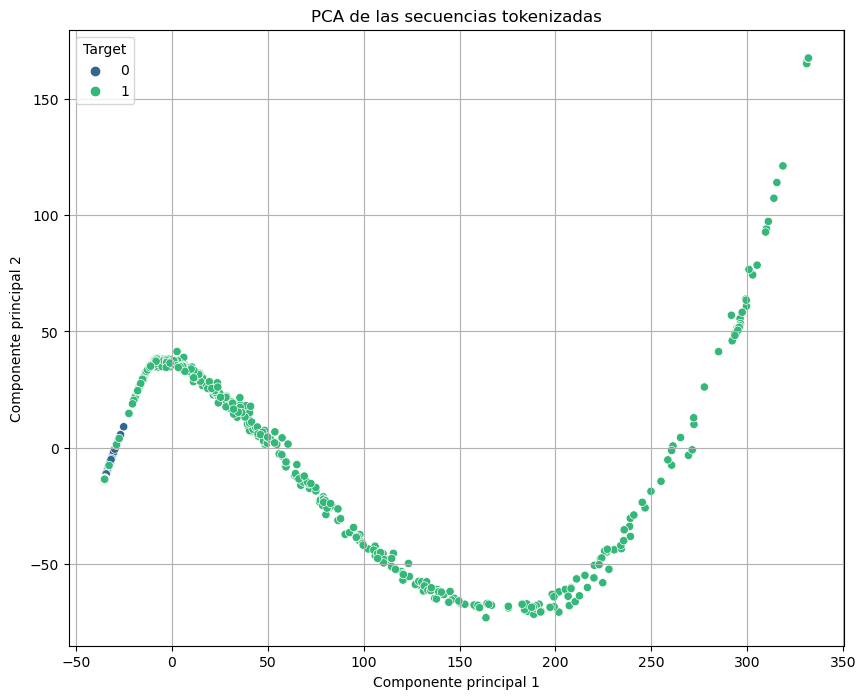

In [76]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC3', hue='Target', palette='viridis', data=pca_df, legend='full')

# Customize the plot
plt.title('PCA de las secuencias tokenizadas')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
#plt.legend(title='Target', labels=labels)
plt.grid(True)
plt.show()

# Referencias

[1] Clark, D. P., Pazdernik, N. J., & McGehee, M. R. (2019). Molecular biology. Elsevier.

[2] EMBL-EBI (2024) Functional genmics 1. Disponible en: https://www.ebi.ac.uk/training/online/courses/functional-genomics-i-introduction-and-design/

[3] Grešová, K., Martinek, V., Čechák, D., Šimeček, P., & Alexiou, P. (2023). Genomic benchmarks: a collection of datasets for genomic sequence classification. BMC Genomic Data, 24(1), 25.

[4] Angermueller, C., Pärnamaa, T., Parts, L., & Stegle, O. (2016). Deep learning for computational biology. Molecular systems biology, 12(7), 878.